In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.layers import Dropout
from keras.models import Model

In [2]:
!pip list

Package                            Version
---------------------------------- --------------------
-illow                             8.2.0
-pencv-contrib-python              4.5.4.60
-tatsmodels                        0.12.2
absl-py                            1.1.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.6
awscli                             1.25.12
Babel                            

In [3]:
import zipfile
local_zip = './backup/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()


qtconsole                          5.0.3
QtPy                               1.9.0
readme-renderer                    35.0
regex                              2021.4.4
rendering                          0.0.0
reportlab                          3.6.11
requests                           2.28.0
requests-oauthlib                  1.3.1
requests-toolbelt                  0.9.1
rfc3986                            2.0.0
rich                               12.4.4
roboflow                           0.2.20
rope                               0.18.0
rsa                                4.7.2
Rtree                              0.9.7
ruamel-yaml-conda                  0.15.100
ruamel.yaml                        0.17.21
ruamel.yaml.clib                   0.2.6
s3transfer                         0.6.0
Sastrawi                           1.0.1
scikit-image                       0.18.1
scikit-learn                       1.1.1
scipy                              1.4.1
seaborn                            0.11.1
s

In [4]:
Lok = '/tmp/dataset/'

In [5]:
os.listdir('/tmp/dataset/')

['test', 'train']

# 2. Image Acquistion

In [6]:
kelas = []
n_gmbar = []
data = {'KualitasDaging':[], 'JumlahFoto':[]}

for i in os.listdir(Lok+'/train'):
    n_gmbar.append(len(os.listdir(Lok+'/train/'+i)))
    kelas.append(i)
    
data['KualitasDaging']+=kelas
data['JumlahFoto']+=n_gmbar

df = pd.DataFrame(data)
df

,KualitasDaging,JumlahFoto
0,AyamSegar,173
1,AyamTiren,200


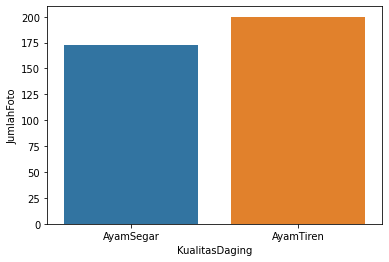

In [7]:
sns.barplot(x=df['KualitasDaging'], y=df['JumlahFoto'])

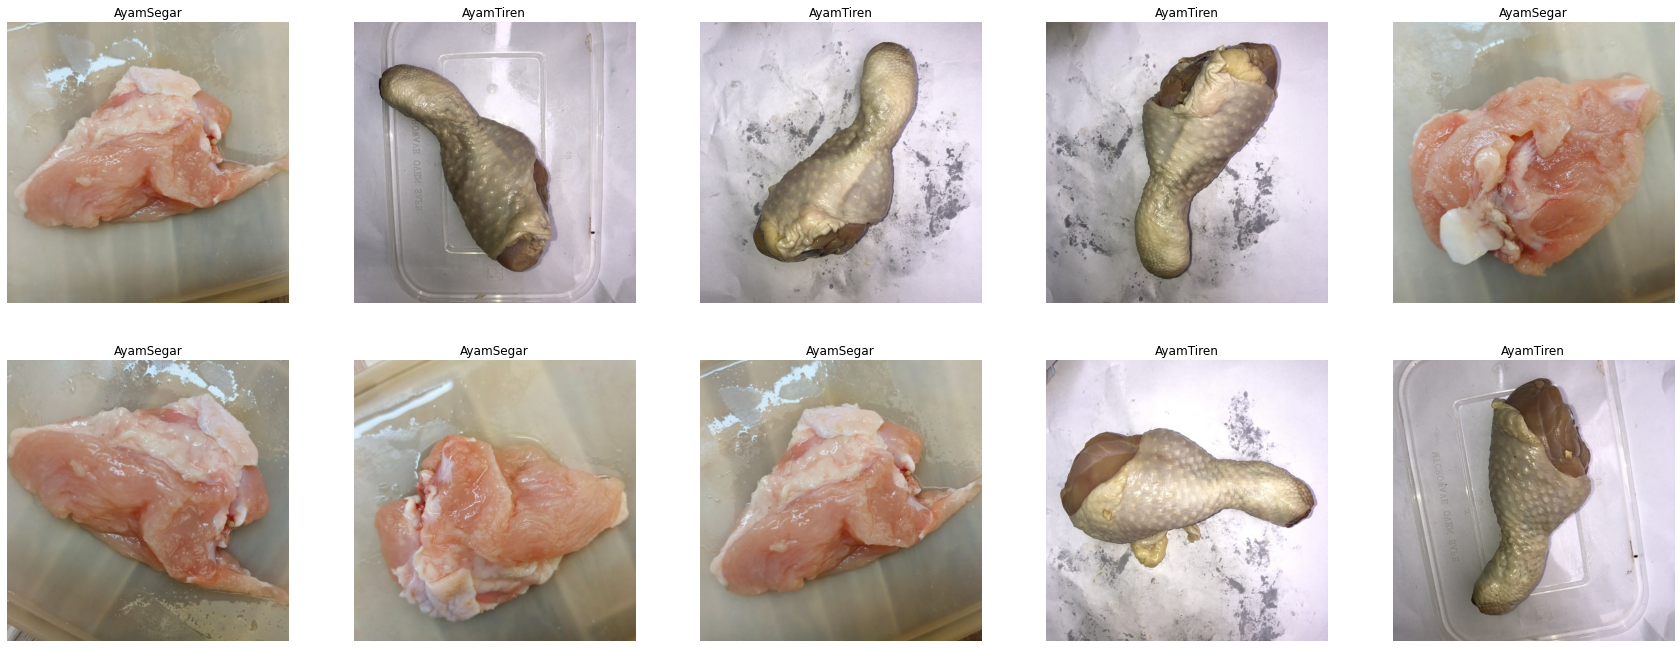

In [8]:
KualitasDaging = os.listdir(Lok+'/train')

plt.figure(figsize=(30,30))
for x in range(10):
    i       = random.randint(0,1)  #mengambbil gambar dari 3 folder
    NamaKls = os.listdir(Lok+'/train'+'/'+KualitasDaging[i])
    
    j          = random.randint(0,100)
    gmbr       = cv2.imread(Lok+'/train'+'/'+KualitasDaging[i]+'/'+NamaKls[j])
    gmbr       = cv2.cvtColor(gmbr, cv2.COLOR_BGR2RGB)
    ax         = plt.subplot(5, 5, x+1)
    plt.imshow(gmbr)
    plt.title(KualitasDaging[i])
    plt.axis("off")
    
plt.show()

# 3. Pre-processing

In [9]:
image_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                               rotation_range=20,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2,
                                                              horizontal_flip=True,
                                                              validation_split=0.2)

In [10]:
train_ds = image_datagen.flow_from_directory(Lok+'/train',
                                            subset='training',
                                            target_size=(150, 150),
                                            batch_size=10)

val_ds   = image_datagen.flow_from_directory(Lok+'/train',
                                            subset='validation',
                                            target_size=(150, 150),
                                            batch_size=10) 

Found 299 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


# 4. Modeling

## 4.1 Model InceptionV3

In [11]:
from tensorflow.keras.applications import InceptionV3


ModelInceptionV3 = tf.keras.models.Sequential([
    tf.keras.applications.InceptionV3(input_shape=(150, 150, 3),
                                         include_top=False,
                                         pooling='max',
                                         weights='imagenet'),
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(256, activation='ReLU'),
    tf.keras.layers.Dense(128, activation='ReLU'),
#    tf.keras.layers.Dense(64, activation='ReLU'),
#    tf.keras.layers.Dense(32, activation='ReLU'),
    tf.keras.layers.Dense(16, activation='ReLU'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(2, activation='softmax')
])

In [12]:
ModelInceptionV3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,
                                                momentum=0.9
                                                 ), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

ModelInceptionV3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 22,067,154
Trainable params: 22,032,722
No

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
CegahUnderOrOver = EarlyStopping(monitor='val_accuracy',
                                patience=10,
                                min_delta=0.001,
                                mode='max',
                                restore_best_weights=True
                                )

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                            factor=0.3,
                            patience=8,
                            min_lr=0.001,
                            mode='auto',
                            verbose=1)

In [15]:
%%time
train_InceptionV3 = ModelInceptionV3.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[CegahUnderOrOver, reducelr])

Epoch 1/12
30/30 [==============================] - 57s 1s/step - loss: 0.8989 - accuracy: 0.6488 - val_loss: 0.4984 - val_accuracy: 0.7838 - lr: 1.0000e-04
Epoch 2/12
30/30 [==============================] - 38s 1s/step - loss: 0.4178 - accuracy: 0.8161 - val_loss: 0.3611 - val_accuracy: 0.8514 - lr: 1.0000e-04
Epoch 3/12
30/30 [==============================] - 38s 1s/step - loss: 0.2422 - accuracy: 0.9264 - val_loss: 0.1879 - val_accuracy: 0.9595 - lr: 1.0000e-04
Epoch 4/12
30/30 [==============================] - 38s 1s/step - loss: 0.2120 - accuracy: 0.9130 - val_loss: 0.0833 - val_accuracy: 0.9730 - lr: 1.0000e-04
Epoch 5/12
30/30 [==============================] - 38s 1s/step - loss: 0.1283 - accuracy: 0.9666 - val_loss: 0.0416 - val_accuracy: 0.9865 - lr: 1.0000e-04
Epoch 6/12
30/30 [==============================] - 38s 1s/step - loss: 0.0655 - accuracy: 0.9766 - val_loss: 0.0586 - val_accuracy: 0.9865 - lr: 1.0000e-04
Epoch 7/12
30/30 [==============================] - 38s 1s

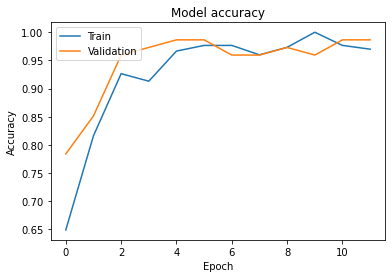

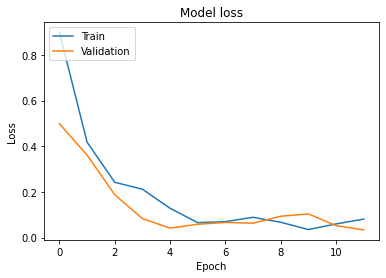

In [16]:
plt.plot(train_InceptionV3.history['accuracy'])
plt.plot(train_InceptionV3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_InceptionV3.history['loss'])
plt.plot(train_InceptionV3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 4.2 Model DenseNet201

In [17]:
ModelDenseNet201 = tf.keras.models.Sequential([
    tf.keras.applications.DenseNet201(input_shape=(150, 150, 3),
                                         include_top=False,
                                         pooling='max',
                                         weights='imagenet'),
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='ReLU'),
    tf.keras.layers.Dense(128, activation='ReLU'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='ReLU'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(2, activation='softmax')
])

In [18]:
ModelDenseNet201.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,
                                                momentum=0.9
                                                 ), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

ModelDenseNet201.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               491776    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [19]:
%%time
train_DenseNet201 = ModelDenseNet201.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[CegahUnderOrOver, reducelr])

Epoch 1/12
30/30 [==============================] - 155s 4s/step - loss: 0.4134 - accuracy: 0.8328 - val_loss: 0.1761 - val_accuracy: 0.9189 - lr: 5.0000e-04
Epoch 2/12
30/30 [==============================] - 109s 4s/step - loss: 0.0288 - accuracy: 0.9933 - val_loss: 0.0069 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 3/12
30/30 [==============================] - 107s 4s/step - loss: 0.0275 - accuracy: 0.9900 - val_loss: 0.0045 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 4/12
30/30 [==============================] - 113s 4s/step - loss: 0.0315 - accuracy: 0.9833 - val_loss: 7.1147e-04 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 5/12
30/30 [==============================] - 112s 4s/step - loss: 0.0122 - accuracy: 0.9967 - val_loss: 8.6341e-04 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 6/12
30/30 [==============================] - 108s 4s/step - loss: 0.0197 - accuracy: 0.9967 - val_loss: 0.0047 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 7/12
30/30 [==========================

## 4.3 Modeling VGG16

In [20]:
from tensorflow.keras.applications import VGG16

ModelVGG16 = tf.keras.models.Sequential([
    tf.keras.applications.VGG16(input_shape=(150, 150, 3),
                                         include_top=False,
                                         pooling='max',
                                         weights='imagenet'),
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='ReLU'),
    tf.keras.layers.Dense(128, activation='ReLU'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='ReLU'),
    tf.keras.layers.Dense(32, activation='ReLU'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='ReLU'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(2, activation='softmax')
])

In [21]:
ModelVGG16.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,
                                                momentum=0.9
                                                 ), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

ModelVGG16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)               

In [22]:
%%time
train_VGG16 = ModelVGG16.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[CegahUnderOrOver, reducelr])

Epoch 1/12
30/30 [==============================] - 82s 3s/step - loss: 0.6849 - accuracy: 0.5585 - val_loss: 0.6618 - val_accuracy: 0.7703 - lr: 1.0000e-04
Epoch 2/12
30/30 [==============================] - 80s 3s/step - loss: 0.6514 - accuracy: 0.6589 - val_loss: 0.6373 - val_accuracy: 0.9189 - lr: 1.0000e-04
Epoch 3/12
30/30 [==============================] - 80s 3s/step - loss: 0.6221 - accuracy: 0.7090 - val_loss: 0.5991 - val_accuracy: 0.9730 - lr: 1.0000e-04
Epoch 4/12
30/30 [==============================] - 83s 3s/step - loss: 0.6010 - accuracy: 0.7124 - val_loss: 0.5221 - val_accuracy: 0.9865 - lr: 1.0000e-04
Epoch 5/12
30/30 [==============================] - 83s 3s/step - loss: 0.5369 - accuracy: 0.7893 - val_loss: 0.4433 - val_accuracy: 0.9730 - lr: 1.0000e-04
Epoch 6/12
30/30 [==============================] - 84s 3s/step - loss: 0.4560 - accuracy: 0.8562 - val_loss: 0.2908 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/12
30/30 [==============================] - 85s 3s

# 5. Evaluasi Model

8/8 [==============================] - 6s 758ms/step - loss: 0.0021 - accuracy: 1.0000


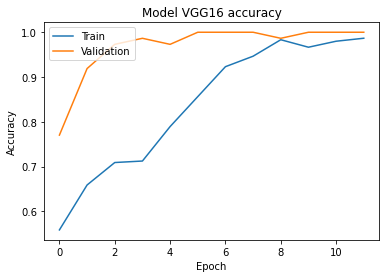

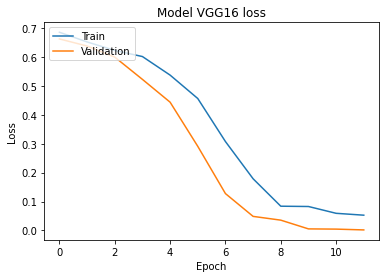

In [23]:
ModelVGG16.evaluate(val_ds)

plt.plot(train_VGG16.history['accuracy'])
plt.plot(train_VGG16.history['val_accuracy'])
plt.title('Model VGG16 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_VGG16.history['loss'])
plt.plot(train_VGG16.history['val_loss'])
plt.title('Model VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

8/8 [==============================] - 5s 591ms/step - loss: 0.0064 - accuracy: 1.0000


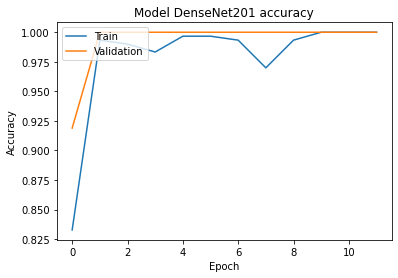

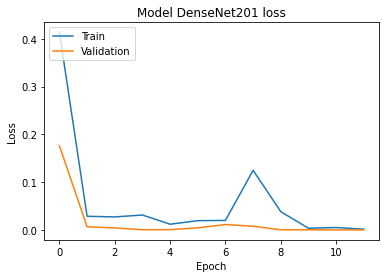

In [24]:
ModelDenseNet201.evaluate(val_ds)

plt.plot(train_DenseNet201.history['accuracy'])
plt.plot(train_DenseNet201.history['val_accuracy'])
plt.title('Model DenseNet201 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_DenseNet201.history['loss'])
plt.plot(train_DenseNet201.history['val_loss'])
plt.title('Model DenseNet201 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

8/8 [==============================] - 2s 223ms/step - loss: 0.0059 - accuracy: 1.0000


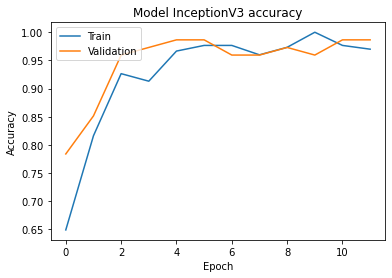

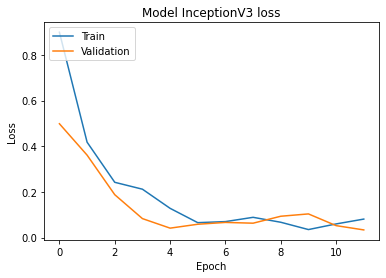

In [25]:
ModelInceptionV3.evaluate(val_ds)

plt.plot(train_InceptionV3.history['accuracy'])
plt.plot(train_InceptionV3.history['val_accuracy'])
plt.title('Model InceptionV3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_InceptionV3.history['loss'])
plt.plot(train_InceptionV3.history['val_loss'])
plt.title('Model InceptionV3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluasi data test dg Confusion matrik

In [28]:
sub_csv ='./backup/Book12.csv'
path_test = './dataset/test/'

In [29]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,36-0,0
1,20221104_081206,0
2,20221104_081209,0
3,Chicken-Whole-Leg2,0
4,IMG_4911,0
5,IMG_4912,0
6,IMG_4913,0
7,IMG_4914,0
8,IMG_4915,0
9,IMG_4916,0


In [30]:
# Masing-masing gambar akan diperlakukan secara individual dan disimpan dalam daftar yang kemudian bergabung dengan ID file tersebut

from tensorflow.keras.preprocessing.image import load_img


# membuat daftar yg diprediksi
labels = []


for i in image_id:
    image = load_img('./backup/dataset/test/'+str(i)+'.jpg', target_size=(150, 150))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,150,150,3)
    label = ModelDenseNet201.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 129ms/step


In [31]:
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,36-0,1
1,20221104_081206,0
2,20221104_081209,0
3,Chicken-Whole-Leg2,0
4,IMG_4911,1
5,IMG_4912,1
6,IMG_4913,1
7,IMG_4914,1
8,IMG_4915,1
9,IMG_4916,1


In [32]:
df_prediksi_test = pd.DataFrame({'image_name':image_id,
                                 'prediksi':labels})

In [33]:
df_prediksi_test

,image_name,prediksi
0,36-0,1
1,20221104_081206,0
2,20221104_081209,0
3,Chicken-Whole-Leg2,0
4,IMG_4911,1
5,IMG_4912,1
6,IMG_4913,1
7,IMG_4914,1
8,IMG_4915,1
9,IMG_4916,1


In [34]:
df_prediksi_test.replace(to_replace=[0, 1], value=["AyamSegar", "AyamTiren"], inplace=True)

In [35]:
df_prediksi_test

,image_name,prediksi
0,36-0,AyamTiren
1,20221104_081206,AyamSegar
2,20221104_081209,AyamSegar
3,Chicken-Whole-Leg2,AyamSegar
4,IMG_4911,AyamTiren
5,IMG_4912,AyamTiren
6,IMG_4913,AyamTiren
7,IMG_4914,AyamTiren
8,IMG_4915,AyamTiren
9,IMG_4916,AyamTiren


In [36]:
df_prediksi_test.to_csv("DataPrediksiTest2.csv", index=False)

In [37]:
ds_aktual = pd.read_csv("./DataTest.csv")
ds_predict = pd.read_csv("./DataPrediksiTest2.csv")


In [38]:
ds_aktual.rename(columns={'prediksi':'label'}, inplace=True)

In [39]:
ds_aktual

,image_name,label
0,36-0,AyamTiren
1,20221104_081206,AyamSegar
2,20221104_081209,AyamSegar
3,Chicken-Whole-Leg2,AyamSegar
4,IMG_4911,AyamTiren
5,IMG_4912,AyamTiren
6,IMG_4913,AyamTiren
7,IMG_4914,AyamTiren
8,IMG_4915,AyamTiren
9,IMG_4916,AyamTiren


In [40]:
df_test_eval = pd.merge(
    ds_predict,
    ds_aktual,
    how="inner",
    on='image_name')

In [41]:
df_test_eval

,image_name,prediksi,label
0,36-0,AyamTiren,AyamTiren
1,20221104_081206,AyamSegar,AyamSegar
2,20221104_081209,AyamSegar,AyamSegar
3,Chicken-Whole-Leg2,AyamSegar,AyamSegar
4,IMG_4911,AyamTiren,AyamTiren
5,IMG_4912,AyamTiren,AyamTiren
6,IMG_4913,AyamTiren,AyamTiren
7,IMG_4914,AyamTiren,AyamTiren
8,IMG_4915,AyamTiren,AyamTiren
9,IMG_4916,AyamTiren,AyamTiren


## Eval Model DenseNet201 punya

In [42]:
from sklearn.metrics import confusion_matrix
y_actual = df_test_eval['label']
y_pred = df_test_eval['prediksi']
confusion_matrix(y_actual, y_pred)

array([[ 6,  0],
       [ 0, 13]], dtype=int64)

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

   AyamSegar       1.00      1.00      1.00         6
   AyamTiren       1.00      1.00      1.00        13

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



# Evaluasi data train

In [44]:
sub_csv ='./backup/dataTrain.csv'
path_test = './backup/dataset-real/dataset/train/'

In [45]:
df_sub_train = pd.read_csv(sub_csv)
image_id = df_sub_train['ID']
df_sub_train.head(10)

,ID,label
0,20221104_081212,AyamSegar
1,20221104_081215,AyamSegar
2,20221104_081217,AyamSegar
3,20221104_081220,AyamSegar
4,20221104_081222,AyamSegar
5,20221104_081226,AyamSegar
6,20221104_081228,AyamSegar
7,20221104_081233,AyamSegar
8,20221104_081237,AyamSegar
9,20221104_081241,AyamSegar


In [46]:
# Masing-masing gambar akan diperlakukan secara individual dan disimpan dalam daftar yang kemudian bergabung dengan ID file tersebut

from tensorflow.keras.preprocessing.image import load_img


# membuat daftar yg diprediksi
labels = []


for i in image_id:
    image = load_img('./backup/dataset-real/dataset/train/'+str(i)+'.jpg', target_size=(150, 150))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,150,150,3)
    label = ModelDenseNet201.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 107ms/step


In [47]:
df_sub_train['Label'] = labels
df_sub_train.head(10)

,ID,label,Label
0,20221104_081212,AyamSegar,0
1,20221104_081215,AyamSegar,0
2,20221104_081217,AyamSegar,0
3,20221104_081220,AyamSegar,0
4,20221104_081222,AyamSegar,0
5,20221104_081226,AyamSegar,0
6,20221104_081228,AyamSegar,0
7,20221104_081233,AyamSegar,0
8,20221104_081237,AyamSegar,0
9,20221104_081241,AyamSegar,0


In [48]:
df_prediksi_train = pd.DataFrame({'image_name':image_id,
                                 'prediksi':labels})

In [49]:
df_prediksi_train

,image_name,prediksi
0,20221104_081212,0
1,20221104_081215,0
2,20221104_081217,0
3,20221104_081220,0
4,20221104_081222,0
...,...,...
368,IMG_5121,1
369,IMG_5122,1
370,IMG_5123,1
371,IMG_5124,1


In [56]:
df_prediksi_train.replace(to_replace=[0, 1], value=["AyamSegar", "AyamTiren"], inplace=True)

In [58]:
df_prediksi_train.to_csv("DataPrediksiTrainValid.csv", index=False)

In [59]:
ds_aktual_train = pd.read_csv("./backup/dataTrain.csv")
ds_predict_train = pd.read_csv("./DataPrediksiTrainValid.csv")

In [60]:
ds_aktual_train

,image_name,label
0,20221104_081212,AyamSegar
1,20221104_081215,AyamSegar
2,20221104_081217,AyamSegar
3,20221104_081220,AyamSegar
4,20221104_081222,AyamSegar
...,...,...
368,IMG_5121,AyamTiren
369,IMG_5122,AyamTiren
370,IMG_5123,AyamTiren
371,IMG_5124,AyamTiren


In [61]:
df_train_eval = pd.merge(
    ds_aktual_train,
    ds_predict_train,
    how="inner",
    on='image_name')

In [62]:
df_train_eval

,image_name,label,prediksi
0,20221104_081212,AyamSegar,AyamSegar
1,20221104_081215,AyamSegar,AyamSegar
2,20221104_081217,AyamSegar,AyamSegar
3,20221104_081220,AyamSegar,AyamSegar
4,20221104_081222,AyamSegar,AyamSegar
...,...,...,...
368,IMG_5121,AyamTiren,AyamTiren
369,IMG_5122,AyamTiren,AyamTiren
370,IMG_5123,AyamTiren,AyamTiren
371,IMG_5124,AyamTiren,AyamTiren


## Eval model DenseNet201 punya

In [63]:
from sklearn.metrics import confusion_matrix
y_actual = df_train_eval['label']
y_pred = df_train_eval['prediksi']
confusion_matrix(y_actual, y_pred)

array([[173,   0],
       [  0, 200]], dtype=int64)

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

   AyamSegar       1.00      1.00      1.00       173
   AyamTiren       1.00      1.00      1.00       200

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373



In [66]:
pwd

'C:\\Users\\ASUS\\LatihanPython_DanielMorantha\\Orbit\\Practical\\Proyek Akhir\\DanielMrnth-KodeNModel'

**Simpan Model**

In [67]:
ModelDenseNet201.save("AyamDenseNet201-DanielMrnth.h5")
# ModelVGG16.save("Ayam-VGG16-DanielMrnth.h5")
# ModelInceptionV3.save("Ayam-InceptionV3-DanielMrnth.h5")

In [27]:
# import glob
# import os.path
# file_test_images = glob.glob('./dataset/test/20221104_081209.jpg')

## Prediksi pakai colab

In [ ]:
# import matplotlib.image as mpimg
# import numpy as np
# from io import BytesIO
# from IPython.display import Image as IMG
# import files
# from keras.preprocessing import image
# from shutil import copyfile

In [ ]:
# def PredGambar(file_gmbr, model = ModelDenseNet201):
#   file = file_gmbr
#   gmbr_array = np.asarray(file)
#   gmbr_array = gmbr_array*(1/225)
#   gmbr_input = tf.reshape(gmbr_array, shape = [1, 150, 150, 3])

#   predik_array = model.predict(gmbr_input)[0]

#   df = pd.DataFrame(predik_array)
#   df = df.rename({0:'NilaiKemiripan'}, axis = 'columns')
#   Kualitas = ['AyamSegar', 'AyamTiren']
#   df['Kelas'] = Kualitas
#   df = df[['Kelas', 'NilaiKemiripan']]

#   predik_kelas = np.argmax(model.predict(gmbr_input))

#   if predik_kelas == 0:
#     predik_Kualitas = 'AyamSegar'
#   else:
#     predik_Kualitas = 'AyamTiren'

#   return predik_Kualitas, df
    

In [ ]:
# import keras
# import tensorflow as tf
# from tensorflow.keras.utils import load_img, img_to_array




# UnggahFile = files.upload()

# for n in UnggahFile.keys():
#   lok = n
#   gmbr = keras.utils.load_img(lok, target_size=(150,150))
#   gmbrPlot = plt.imshow(gmbr)
#   x = keras.utils.img_to_array(gmbr)
#   x = np.expand_dims(x, axis=0)
#   gmbr = np.vstack([x])

#   kelas, df = PredGambar(gmbr)

#   print('\n')
#   plt.show()
#   print("\nGambar dikenali sebagai " + kelas)
#   print('\n')
#   print(df)
#   print('\n')

In [ ]:
# import keras
# import tensorflow as tf
# from tensorflow.keras.utils import load_img, img_to_array




# UFile = files.upload()

# for n in UFile.keys():
#   lok = n
#   gmbr = keras.utils.load_img(lok, target_size=(150,150))
#   gmbrPlot = plt.imshow(gmbr)
#   x = keras.utils.img_to_array(gmbr)
#   x = np.expand_dims(x, axis=0)
#   gmbr = np.vstack([x])

#   kelas, df = PredGambar(gmbr)

#   print('\n')
#   plt.show()
#   print("\nGambar dikenali sebagai " + kelas)
#   print('\n')
#   print(df)
#   print('\n')

In [ ]:
# import keras
# import tensorflow as tf
# from tensorflow.keras.utils import load_img, img_to_array




# UngFile = files.upload()

# for n in UngFile.keys():
#   lok = n
#   gmbr = keras.utils.load_img(lok, target_size=(150,150))
#   gmbrPlot = plt.imshow(gmbr)
#   x = keras.utils.img_to_array(gmbr)
#   x = np.expand_dims(x, axis=0)
#   gmbr = np.vstack([x])

#   kelas, df = PredGambar(gmbr)

#   print('\n')
#   plt.show()
#   print("\nGambar dikenali sebagai " + kelas)
#   print('\n')
#   print(df)
#   print('\n')